In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
cancer_types = {
    1: 'Oponiak',
    2: 'Glejak',
    3: 'Guz przysadki'
}

### Wczytanie danych procesowania
Dostępne dane składają się ze zdjęć zapisanych w formacie Matlab (.map). Każdy plik zawiera min. zdjęcie (image) oraz etykietę (label).

In [3]:
data_dir = 'data'
mri_images = []
labels = []

for file_name in os.listdir(data_dir):
    file_path = os.path.join(data_dir, file_name)
    file_mat = h5py.File(file_path, "r")
    image = np.array(file_mat['/cjdata/image'])
    image = Image.fromarray(image).resize((128, 128))
    mri_images.append(np.array(image))
    labels.append(file_mat['/cjdata/label'][0][0])

### Przykładowe zdjęcia

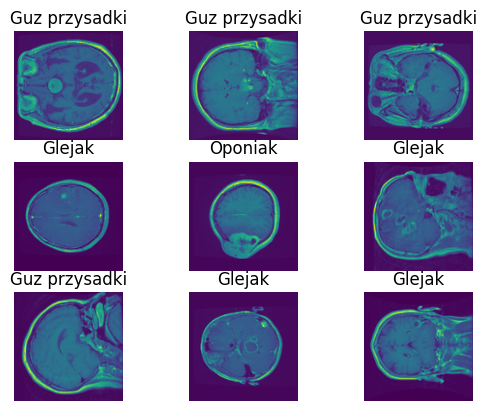

In [4]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(mri_images[i])
    plt.title(cancer_types[int(labels[i])])
    plt.axis("off")

### Zakodowanie etykiet w wykorzystanie One-Hot encodera

In [5]:
# Konieczna jest zmiana kształtu danych etykiet
labels = np.array(labels)
labels_reshaped = labels.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
labels_encoded = encoder.fit_transform(labels_reshaped)

In [6]:
# Zmiana mri_images z tablicy na tablicę numpy
mri_images = np.array(mri_images)

### Podział danych na treningowe i testowe

In [7]:
X_train, X_test, y_train, y_test = train_test_split(mri_images, labels, test_size=0.2, random_state=13)

### Klasyfikacja za pomocą Maszyny Wektorów Nośnych

In [8]:
X_train.shape

(2451, 128, 128)

In [9]:
# Do klasyfikacji za pomoca SVM konieczne będzie spłaszczenie danych wejściowych
X_train_flattened = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_flattened = X_test.reshape(X_test.shape[0], -1) / 255.0

In [10]:
X_train_flattened.shape

(2451, 16384)

In [11]:
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train_flattened, y_train)
y_pred_svm = svm_classifier.predict(X_test_flattened)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_svm, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_svm, normalize = False)
precision = precision_score(y_test, y_pred_svm, average = 'weighted')
recall = recall_score(y_test, y_pred_svm, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.8384991843393148
Accuracy count: 514.0
Precision: 0.8377155561551534
Recall: 0.8384991843393148


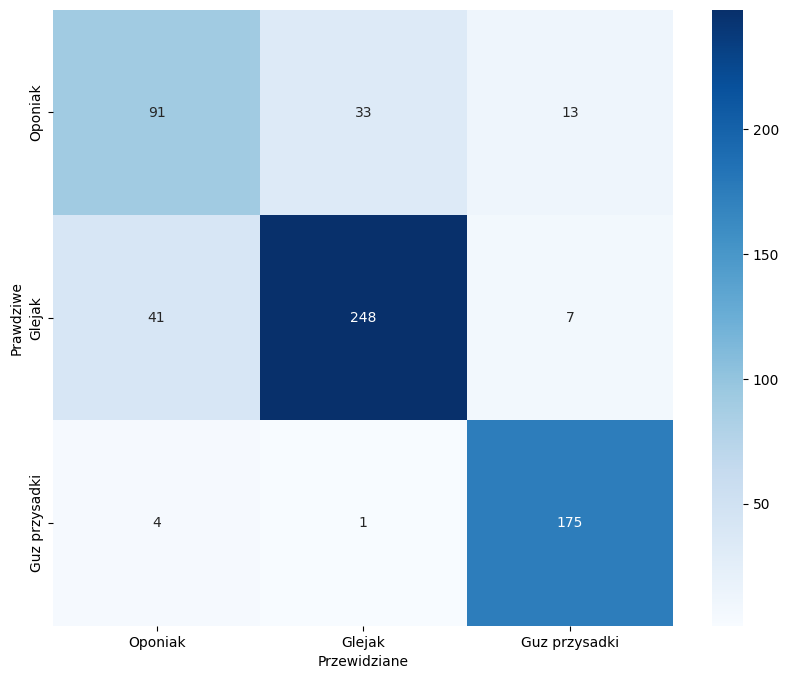

In [13]:
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cancer_types.values(), yticklabels=cancer_types.values())
plt.xlabel("Przewidziane")
plt.ylabel("Prawdziwe")
plt.show()

In [14]:
print(classification_report(y_test, y_pred_svm, target_names=cancer_types.values()))


               precision    recall  f1-score   support

      Oponiak       0.67      0.66      0.67       137
       Glejak       0.88      0.84      0.86       296
Guz przysadki       0.90      0.97      0.93       180

     accuracy                           0.84       613
    macro avg       0.82      0.82      0.82       613
 weighted avg       0.84      0.84      0.84       613



### Klasyfikacja za pomocą XGBoost

In [15]:
# Etykiety powinny być typu int oraz zaczynać się od 0
y_train = y_train.astype(int) - 1

In [16]:
xgb_classifier = XGBClassifier(objective='multi:softprob')
xgb_classifier.fit(X_train_flattened, y_train)
y_pred_xgb = xgb_classifier.predict(X_test_flattened)

In [17]:
y_test = y_test.astype(int) - 1

In [18]:
accuracy = accuracy_score(y_test, y_pred_xgb, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_xgb, normalize = False)
precision = precision_score(y_test, y_pred_xgb, average = 'weighted')
recall = recall_score(y_test, y_pred_xgb, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9477977161500816
Accuracy count: 581.0
Precision: 0.950112646765394
Recall: 0.9477977161500816


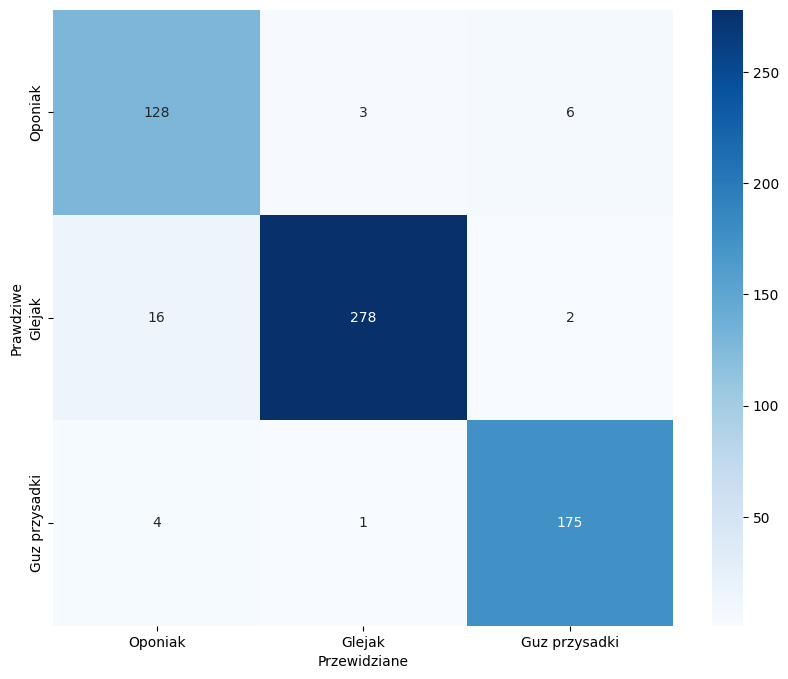

In [19]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cancer_types.values(), yticklabels=cancer_types.values())
plt.xlabel("Przewidziane")
plt.ylabel("Prawdziwe")
plt.show()

In [20]:
print(classification_report(y_test, y_pred_xgb, target_names=cancer_types.values()))


               precision    recall  f1-score   support

      Oponiak       0.86      0.93      0.90       137
       Glejak       0.99      0.94      0.96       296
Guz przysadki       0.96      0.97      0.96       180

     accuracy                           0.95       613
    macro avg       0.94      0.95      0.94       613
 weighted avg       0.95      0.95      0.95       613



### Klasyfikacja za pomocą Lasu Losowego

In [21]:
rf_classifier = RandomForestClassifier(n_estimators=500)
rf_classifier.fit(X_train_flattened, y_train)
y_pred_rf = rf_classifier.predict(X_test_flattened)

In [22]:
accuracy = accuracy_score(y_test, y_pred_rf, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_rf, normalize = False)
precision = precision_score(y_test, y_pred_rf, average = 'weighted')
recall = recall_score(y_test, y_pred_rf, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9461663947797716
Accuracy count: 580.0
Precision: 0.950320172655841
Recall: 0.9461663947797716


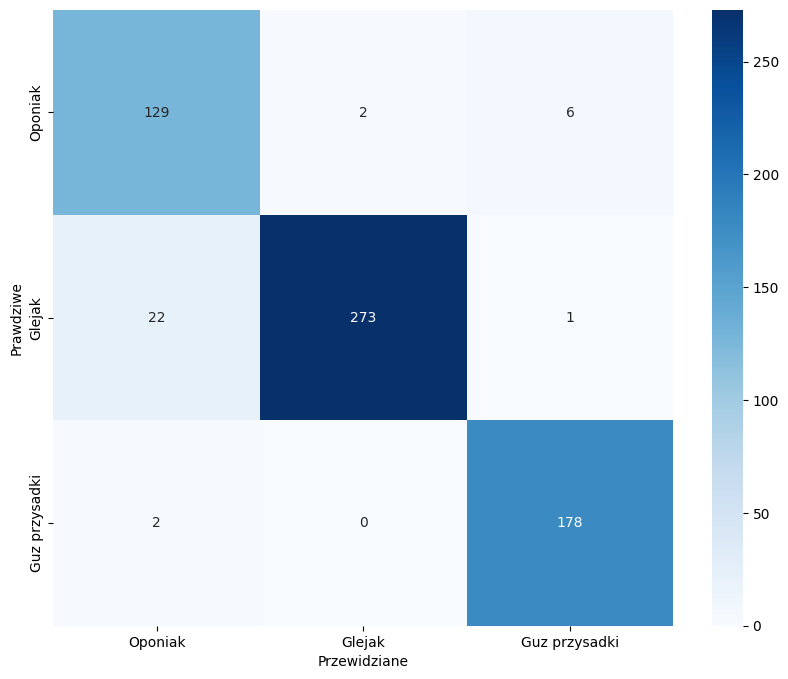

In [23]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cancer_types.values(), yticklabels=cancer_types.values())
plt.xlabel("Przewidziane")
plt.ylabel("Prawdziwe")
plt.show()

In [24]:
print(classification_report(y_test, y_pred_rf, target_names=cancer_types.values()))


               precision    recall  f1-score   support

      Oponiak       0.84      0.94      0.89       137
       Glejak       0.99      0.92      0.96       296
Guz przysadki       0.96      0.99      0.98       180

     accuracy                           0.95       613
    macro avg       0.93      0.95      0.94       613
 weighted avg       0.95      0.95      0.95       613



### Hiperparametryzacja

Co prawda najlepsze wyniki dla analizowanych danych dał XGBoost, ale ze względu na problemy z kompatybilnością XGBoosta z GridSearchem (https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags) hiperparamteryzację wykonamy dla Lasu losowego.

In [29]:
param_grid_rf = {
    'n_estimators': [500, 550, 600],
    'max_depth': [None, 30, 60],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
grid_search_rf =  GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf.fit(X_train_flattened, y_train)

print("Best Parameters for RandomForest:", grid_search_rf.best_params_)
print("Best Cross-Validation Accuracy for RandomForest:", grid_search_rf.best_score_)